In [207]:
# Installing required dependencies by running install_dependencies.sh or by running each
# line of it here with a ! in front of each (ex.: !pip install matplotlib)
# Comment: You may need to update all python packages after installation

In [208]:
# Importing the required packages
import pandas as pd
import xlrd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg
from scipy.stats import norm, t, chi

In [209]:
# Reading data in the file
excel_sheets = pd.read_excel('Camargo_SPanalysis.xlsx', sheet_name='teste')

In [210]:
# Verifying columns in the data sheet
excel_sheets.columns

Index(['VOLUNTÁRIO', 'Grupo', 'BLOCO', 'TRIAL', 'ESTIMULO', 'ACURÁCIA',
       'TENTATIVAS', 'TECLAS_ERRO', 'RESPONSE', 'RT2', 'ANTECIPATED R.',
       'RT ANALISE', 'ORDENS 0/1', 'Análise a partir da repetição de T2',
       'Repetição de F2', '7 TIPOS', 'ÚLTIMA TRANSIÇÃO', 'F1T2 E F1T3',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21',
       'Unnamed: 22'],
      dtype='object')

In [211]:
# Dropping columns that won't be used

excel_sheets = excel_sheets.drop(['TRIAL', 'ACURÁCIA', 'TENTATIVAS', 'TECLAS_ERRO', 'ANTECIPATED R.', 'RT ANALISE', 'ORDENS 0/1', 'Análise a partir da repetição de T2',
        'Repetição de F2', '7 TIPOS', 'ÚLTIMA TRANSIÇÃO', 'F1T2 E F1T3', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22'], axis=1)

In [212]:
# Renaming variables for working

data = excel_sheets.rename(columns={"VOLUNTÁRIO": "volunteer", "Grupo":"group", "BLOCO": "block", "ESTIMULO":"stimuli", "RESPONSE": "response", "RT2": "time"})
data.head()


,volunteer,group,block,stimuli,response,time
0,1,1,1,1,1,0.440657
1,1,1,1,2,2,0.341105
2,1,1,1,2,2,0.197176
3,1,1,1,1,1,0.607489
4,1,1,1,2,2,0.183231


In [213]:
# Creating the columns for identifying the stimulus type 
# types are:
#     - f1
#     - f2
#     - v2
#     - v3
# f stands for fix and v for variable

# declaring variables
p_num = max(data['volunteer'])
stim_type =  list()

# identifying the types
for p in range(1,p_num+1):
    p_data = data.loc[data['volunteer'] == p,:].reset_index(drop=True)
    lines = p_data.shape[0]
    for l in range(lines):
        if p_data['stimuli'][l] == 1:
            stim_type.append('f1')
        elif p_data['stimuli'][l] == 2:
            if l-1 >= 0:
                if p_data['stimuli'][l-1] == 1:
                    stim_type.append('f2')
                else:
                    stim_type.append('v2')
            else:
                if p_data['stimuli'][l+1] == 1:
                    stim_type.append('v2')
                else:
                    stim_type.append('f2')
        else:
            stim_type.append('v3')

data['stim_type'] = stim_type

In [214]:
# Verfication

data.head(n=10)

,volunteer,group,block,stimuli,response,time,stim_type
0,1,1,1,1,1,0.440657,f1
1,1,1,1,2,2,0.341105,f2
2,1,1,1,2,2,0.197176,v2
3,1,1,1,1,1,0.607489,f1
4,1,1,1,2,2,0.183231,f2
5,1,1,1,3,3,0.295534,v3
6,1,1,1,1,1,0.531342,f1
7,1,1,1,2,2,0.297871,f2
8,1,1,1,3,3,0.230926,v3
9,1,1,1,1,1,0.196036,f1


In [218]:
# Separating by group 

data = data.loc[ data['group'] == 2, : ]


In [219]:
data

,volunteer,group,block,stimuli,response,time,stim_type
7500,2,2,1,1,NaN,2.388841,f1
7501,2,2,1,2,NaN,1.176341,f2
7502,2,2,1,2,NaN,0.593418,v2
7503,2,2,1,1,NaN,0.494229,f1
7504,2,2,1,2,NaN,0.518222,f2
...,...,...,...,...,...,...,...
14995,24,2,5,2,NaN,0.066838,f2
14996,24,2,5,2,NaN,0.241157,v2
14997,24,2,5,1,NaN,0.218230,f1
14998,24,2,5,2,NaN,0.098323,f2


In [220]:
# Costructing the desired table

subj = 2;
subj_data = data.loc[ data['volunteer'] == subj, : ]

# Separating data by stim_type
f1 = subj_data.loc[ subj_data['stim_type'] == 'f1', : ]
f2 = subj_data.loc[ subj_data['stim_type'] == 'f2', : ]
v2 = subj_data.loc[ subj_data['stim_type'] == 'v2', : ]
v3 = subj_data.loc[ subj_data['stim_type'] == 'v3', : ]


# Calculating mean and std each stim_typ
f1_m = np.mean(f1['time'])
f1_v = np.var(f1['time'])
f1_sz = f1.shape[0]
f2_m = np.mean(f2['time'])
f2_v = np.var(f2['time'])
f2_sz = f2.shape[0]
v2_m = np.mean(v2['time'])
v2_v = np.var(v2['time'])
v2_sz = v2.shape[0]
v3_m = np.mean(v3['time'])
v3_v = np.var(v3['time'])
v3_sz = v3.shape[0]

df_summ_dict = { 'f1': [f1_m, f1_v, f1_sz], 'f2': [f2_m, f2_v, f2_sz], 'v2': [v2_m, v2_v, v2_sz], 'v3': [v3_m, v3_v, v3_sz]}
df_summ = pd.DataFrame.from_dict(df_summ_dict)


In [221]:
# Verifying

df_summ


,f1,f2,v2,v3
0,0.282572,0.302891,0.396620,0.526861
1,0.172255,0.155814,0.269001,9.332406
2,250.000000,250.000000,65.000000,185.000000


In [222]:
# Confidence interval for the mean

x_m = df_summ['f1'][0]
x_v = df_summ['f1'][1]
gamma_par = 0.95

c = t.ppf( (1/2)*(1+gamma_par), df_summ['f1'][2]-1)
k = np.sqrt(x_v)*c/np.sqrt(x.shape[0])

print( ' The CI interval says with probability of 0.95 that the mean is between ' + format(x_m - k, '.2f' ) + ' and ' + format(x_m + k, '.2f' ) )

 The CI interval says with probability of 0.95 that the mean is between 0.22 and 0.34


In [223]:
# Confidence interval for the variance

gamma_par = 0.95
Fc1 = (1/2)*(1-gamma_par)
Fc2 = (1/2)*(1+gamma_par)
c1 = chi.ppf(Fc1, df_summ['f1'][2]-1)
c2 = chi.ppf(Fc2, df_summ['f1'][2]-1)
k1 = (df_summ['f1'][2]-1)*x_v/c1
k2 = (df_summ['f1'][2]-1)*x_v/c2

print( ' The CI interval says with probability of 0.95 that the mean is between ' + format(k2, '.2f' ) + ' and ' + format(k1, '.2f' ) )

 The CI interval says with probability of 0.95 that the mean is between 2.50 and 2.98


/tmp/ipykernel_2069/2954608383.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  beta = np.trapz(y2[np.where(p > 0.95)[0][0]:], x[np.where(p > 0.95)[0][0]:])
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont: Font family 'Times' not found.
findfont:

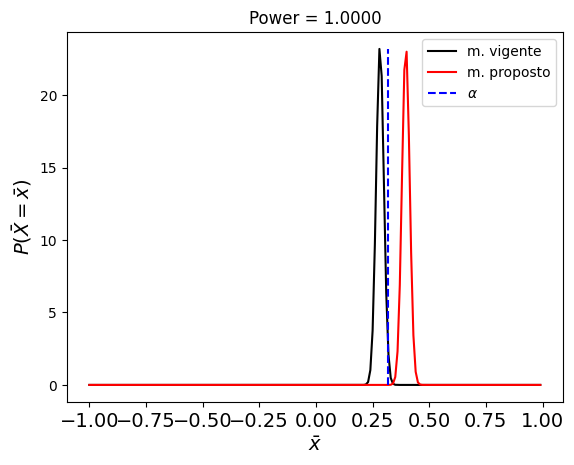

In [226]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
mu1 = 0.282572  # smaller one
mu2 = 0.396620
id_var = 0.269001
sz = 250
x = np.arange(-1, 1, 0.01)

# Normal distributions
y1 = norm.pdf(x, mu1, id_var / np.sqrt(sz))
y2 = norm.pdf(x, mu2, id_var / np.sqrt(sz))

# Plot distributions
plt.plot(x, y1, 'k', label='smaller times')
plt.plot(x, y2, 'r', label='bigger times')

# Labels
plt.xlabel(r'$\bar{x}$', fontsize=14)
plt.ylabel(r'$P (\bar{X} = \bar{x})$', fontsize=14)

# Customize ticks
plt.xticks(fontsize=14, family='Times')

# Add legend
plt.legend()

# Calculate p-values for the first normal distribution
p = norm.cdf(x, mu1, id_var / np.sqrt(sz))

# Find alpha_value corresponding to 0.95 cumulative probability
alpha_value = x[np.where(p > 0.95)[0][0]]

# Calculate beta (area under the curve for y2 where p > 0.95)
beta = np.trapz(y2[np.where(p > 0.95)[0][0]:], x[np.where(p > 0.95)[0][0]:])

# Plot the alpha line
plt.plot(alpha_value * np.ones(100), np.linspace(0, np.max(y1), 100), 'b--')

# Update legend
plt.legend([r'm. vigente', r'm. proposto', r'$\alpha$'])

# Title with Power value (Beta)
plt.title(f'Power = {beta:.4f}')

# Show plot
plt.show()